# Importing the Necessary Packages

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import wandb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pickle


# Loading in the data

In [2]:
train_data = pd.read_csv("/Users/adarsh/Workspace/Personal/Machine-Learning-Classification/data/train.csv")
test_data = pd.read_csv("/Users/adarsh/Workspace/Personal/Machine-Learning-Classification/data/test.csv")

In [3]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### We are now going to use only the `text` and `target` columns.

* 1 - Disaster Tweet
* 0 - Not a Disaster Tweet

## Visualizing the target distribution of the data

<Axes: xlabel='target'>

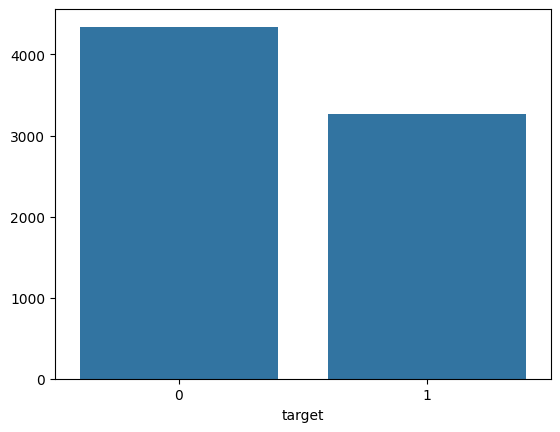

In [4]:
sns.barplot(x=train_data['target'].value_counts().index, y=list(train_data['target'].value_counts()))

## Plotting a word cloud to see which words occur the most

In [5]:
full_text = " ".join(text for text in train_data.text)

In [6]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(full_text)


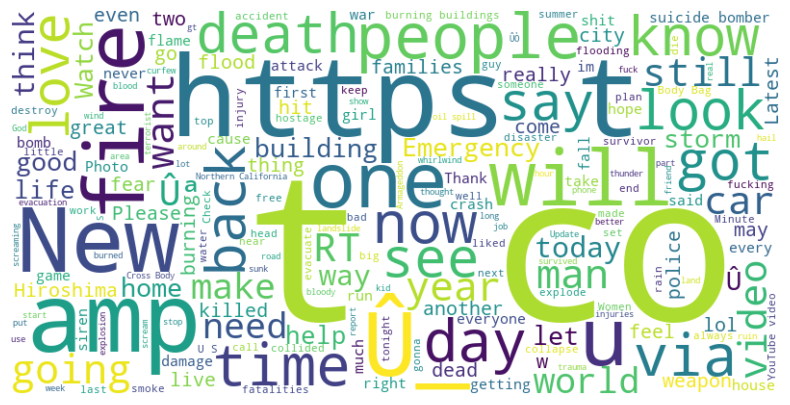

In [7]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis details
plt.show()

We will first just dump in the data into the model and try training the model and see the results

## Training a Count Vectorizer Model

In [8]:
train_data = train_data[["text", "target"]]

In [9]:
X = train_data["text"]
y = train_data["target"]

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

In [11]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_val_cv = cv.transform(X_val)

We are first going to try a linear SVC model as recommended by the sklearn documentation - https://scikit-learn.org/1.3/tutorial/machine_learning_map/index.html
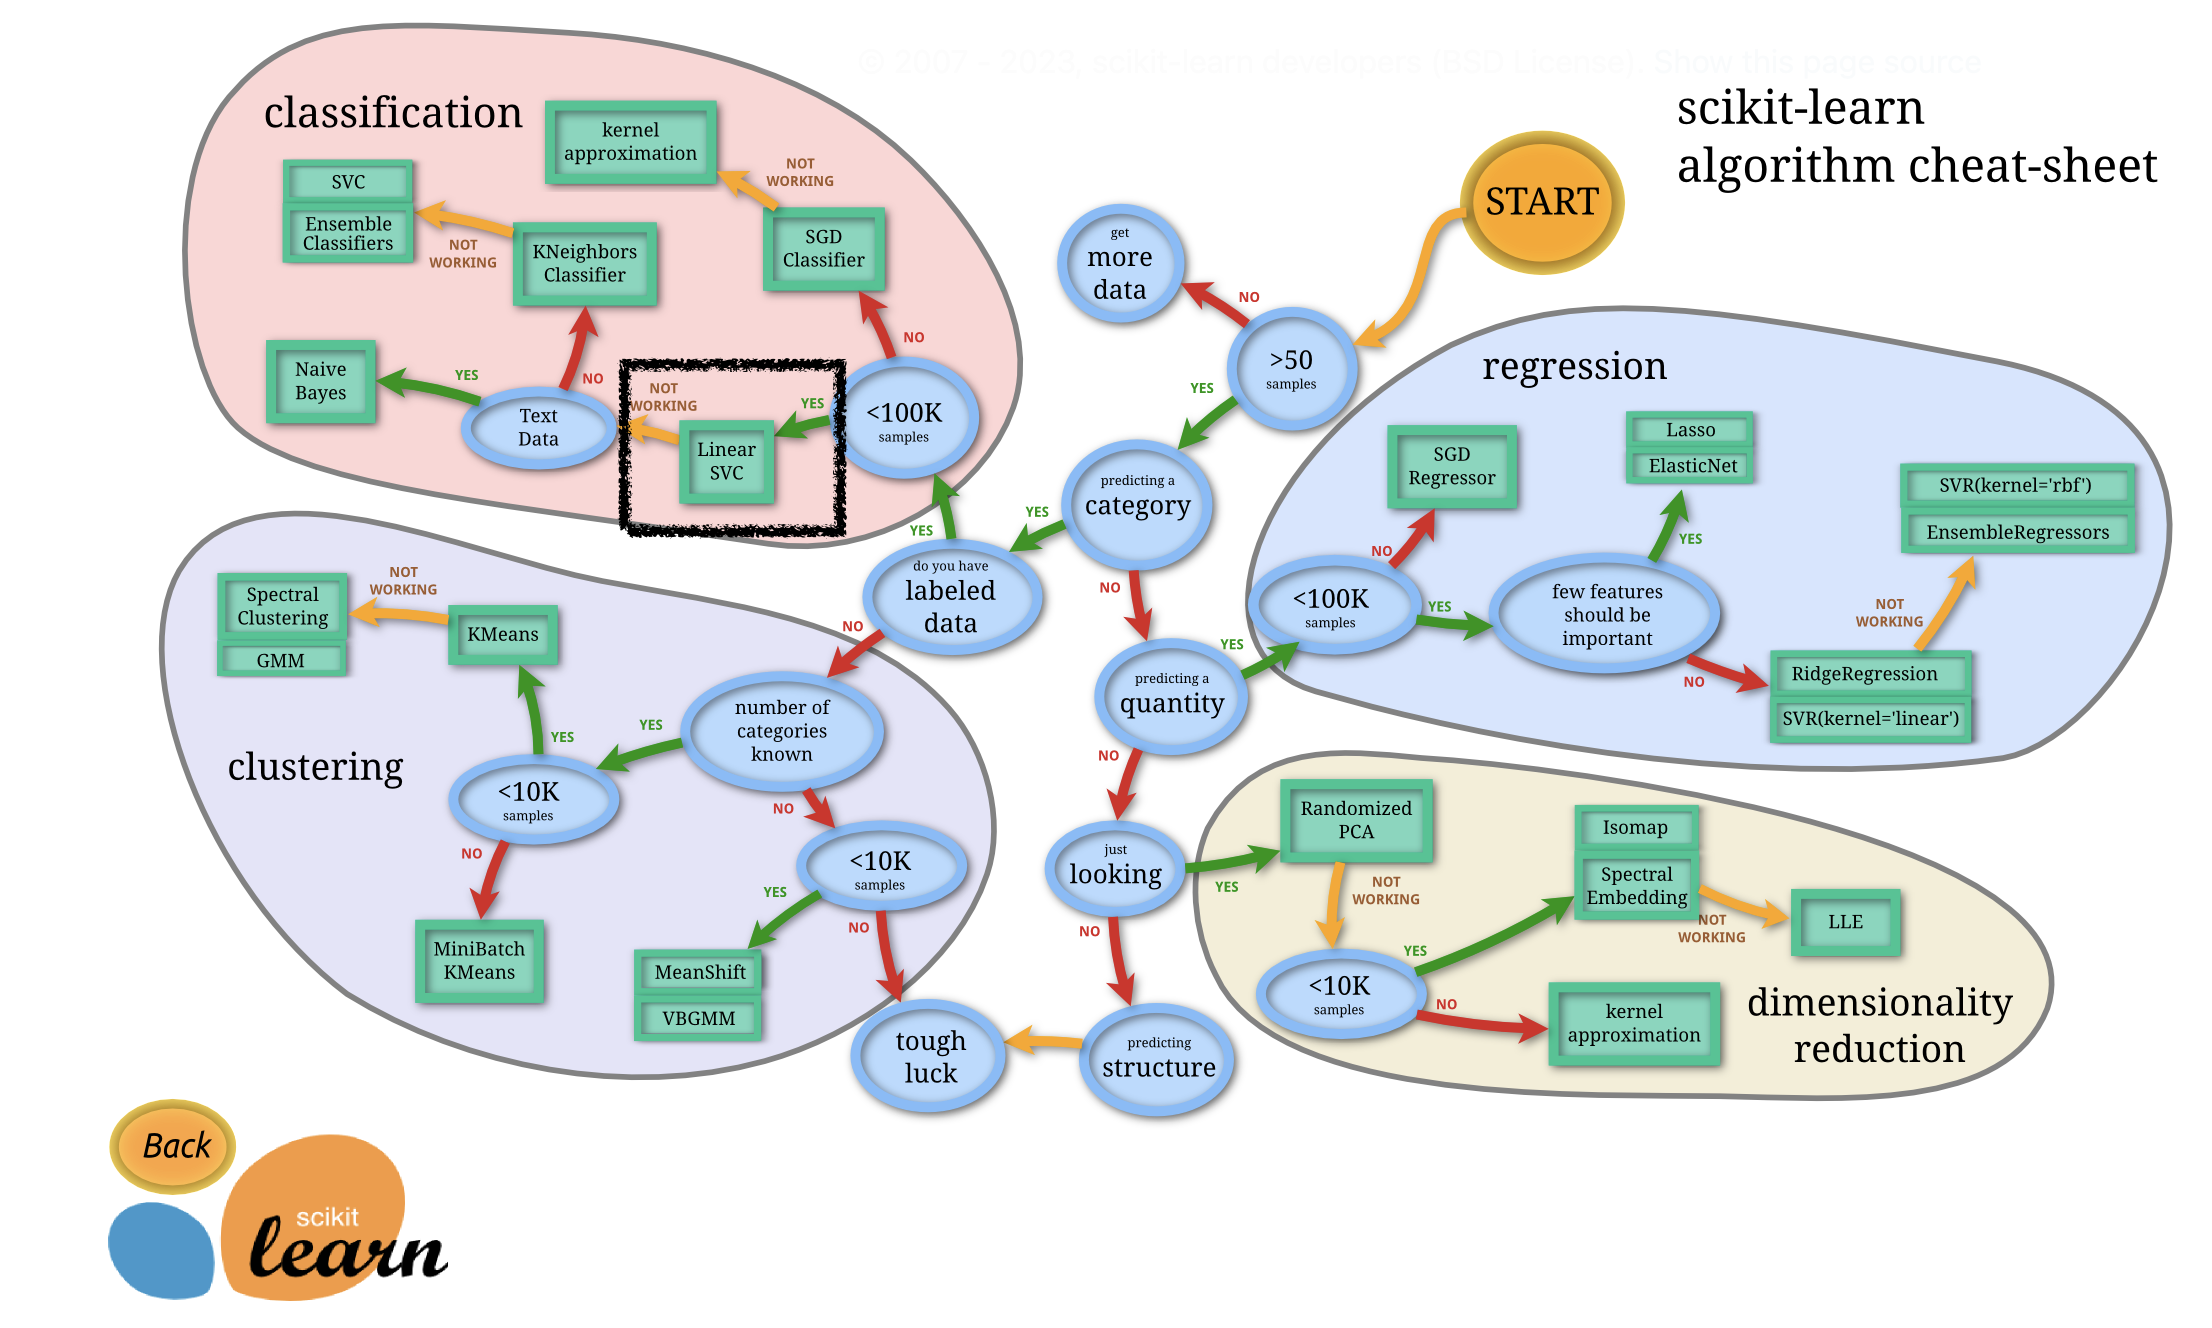


In [12]:
from sklearn.svm import SVC

In [13]:
svc_count_vc = SVC(probability=True)
svc_count_vc.fit(X_train_cv, y_train)

SVC(probability=True)

In [19]:
y_pred_cv = svc_count_vc.predict(X_val_cv)
y_pred_proba_cv = svc_count_vc.predict_proba(X_val_cv)

## Training a TF-IDF Model

In [17]:
tfif_vectorizer = TfidfVectorizer()
X_train_tv = tfif_vectorizer.fit_transform(X_train)
X_val_tv = tfif_vectorizer.transform(X_val)

In [18]:
svc_tfidf_tv = SVC(probability=True)
svc_tfidf_tv.fit(X_train_tv, y_train)

SVC(probability=True)

In [20]:
y_pred_tv = svc_tfidf_tv.predict(X_val_tv)
y_pred_proba_tv = svc_tfidf_tv.predict_proba(X_val_tv)

## Logging Metrics on Weights and Biases

### Step 1: Login to Weights and Biases

In [21]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: adarsh047. Use `wandb login --relogin` to force relogin


True

### Step 2: Initialize Project

In [22]:
wandb.init(project="Disaster Tweet Classification")

### Step 3: Log Classifier Into the dashboard

In [23]:
labels = ["Not a Disaster", "Disaster"]

In [24]:
# Count Vectorizer
wandb.sklearn.plot_classifier(model=svc_count_vc, X_train=X_train_cv, X_test=X_val_cv, y_train=y_train, y_test=y_val, y_pred=y_pred_cv, y_probas=y_pred_proba_cv, model_name="SVC Count Vectorizer", labels=labels)

# TFIDF Vectorizer
wandb.sklearn.plot_classifier(model=svc_tfidf_tv, X_train=X_train_tv, X_test=X_val_tv, y_train=y_train, y_test=y_val, y_pred=y_pred_tv, y_probas=y_pred_proba_tv, model_name="SVC TFIDF Vectorizer", labels=labels)

wandb: 
wandb: Plotting SVC Count Vectorizer.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: 
wandb: Plotting SVC TFIDF Vectorizer.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


### Step 4: Log Classifier Metrics

### Count Vectorizer

In [25]:
accuracy_cv = accuracy_score(y_val, y_pred_cv)
precision_cv = precision_score(y_val, y_pred_cv, average='macro')
recall_cv = recall_score(y_val, y_pred_cv, average='macro')
f1_cv = f1_score(y_val, y_pred_cv, average='macro')
conf_matrix_cv = confusion_matrix(y_val, y_pred_cv)

In [27]:
metrics_table_cv = wandb.Table(columns=["Metric", "Value"])
metrics_table_cv.add_data("Accuracy", accuracy_cv)
metrics_table_cv.add_data("Precision", precision_cv)
metrics_table_cv.add_data("Recall", recall_cv)
metrics_table_cv.add_data("F1 Score", f1_cv)

In [28]:
wandb.log({
    "metrics": metrics_table_cv})

In [29]:
wandb.log({
    "metrics bar plot": wandb.plot.bar(metrics_table_cv, "Metric", "Value",
                              title="Model Metrics")
})


### TFIDF Vectorizer

In [30]:
accuracy_tv = accuracy_score(y_val, y_pred_tv)
precision_tv = precision_score(y_val, y_pred_tv, average='macro')
recall_tv = recall_score(y_val, y_pred_tv, average='macro')
f1_tv = f1_score(y_val, y_pred_tv, average='macro')
conf_matrix_tv = confusion_matrix(y_val, y_pred_tv)

In [32]:
metrics_table_tv = wandb.Table(columns=["Metric", "Value"])
metrics_table_tv.add_data("Accuracy", accuracy_tv)
metrics_table_tv.add_data("Precision", precision_tv)
metrics_table_tv.add_data("Recall", recall_tv)
metrics_table_tv.add_data("F1 Score", f1_tv)

In [33]:
wandb.log({
    "metrics": metrics_table_tv})

In [34]:
wandb.log({
    "metrics bar plot": wandb.plot.bar(metrics_table_tv, "Metric", "Value",
                              title="Model Metrics")
})

## Metrics Captured From Weights And Biases
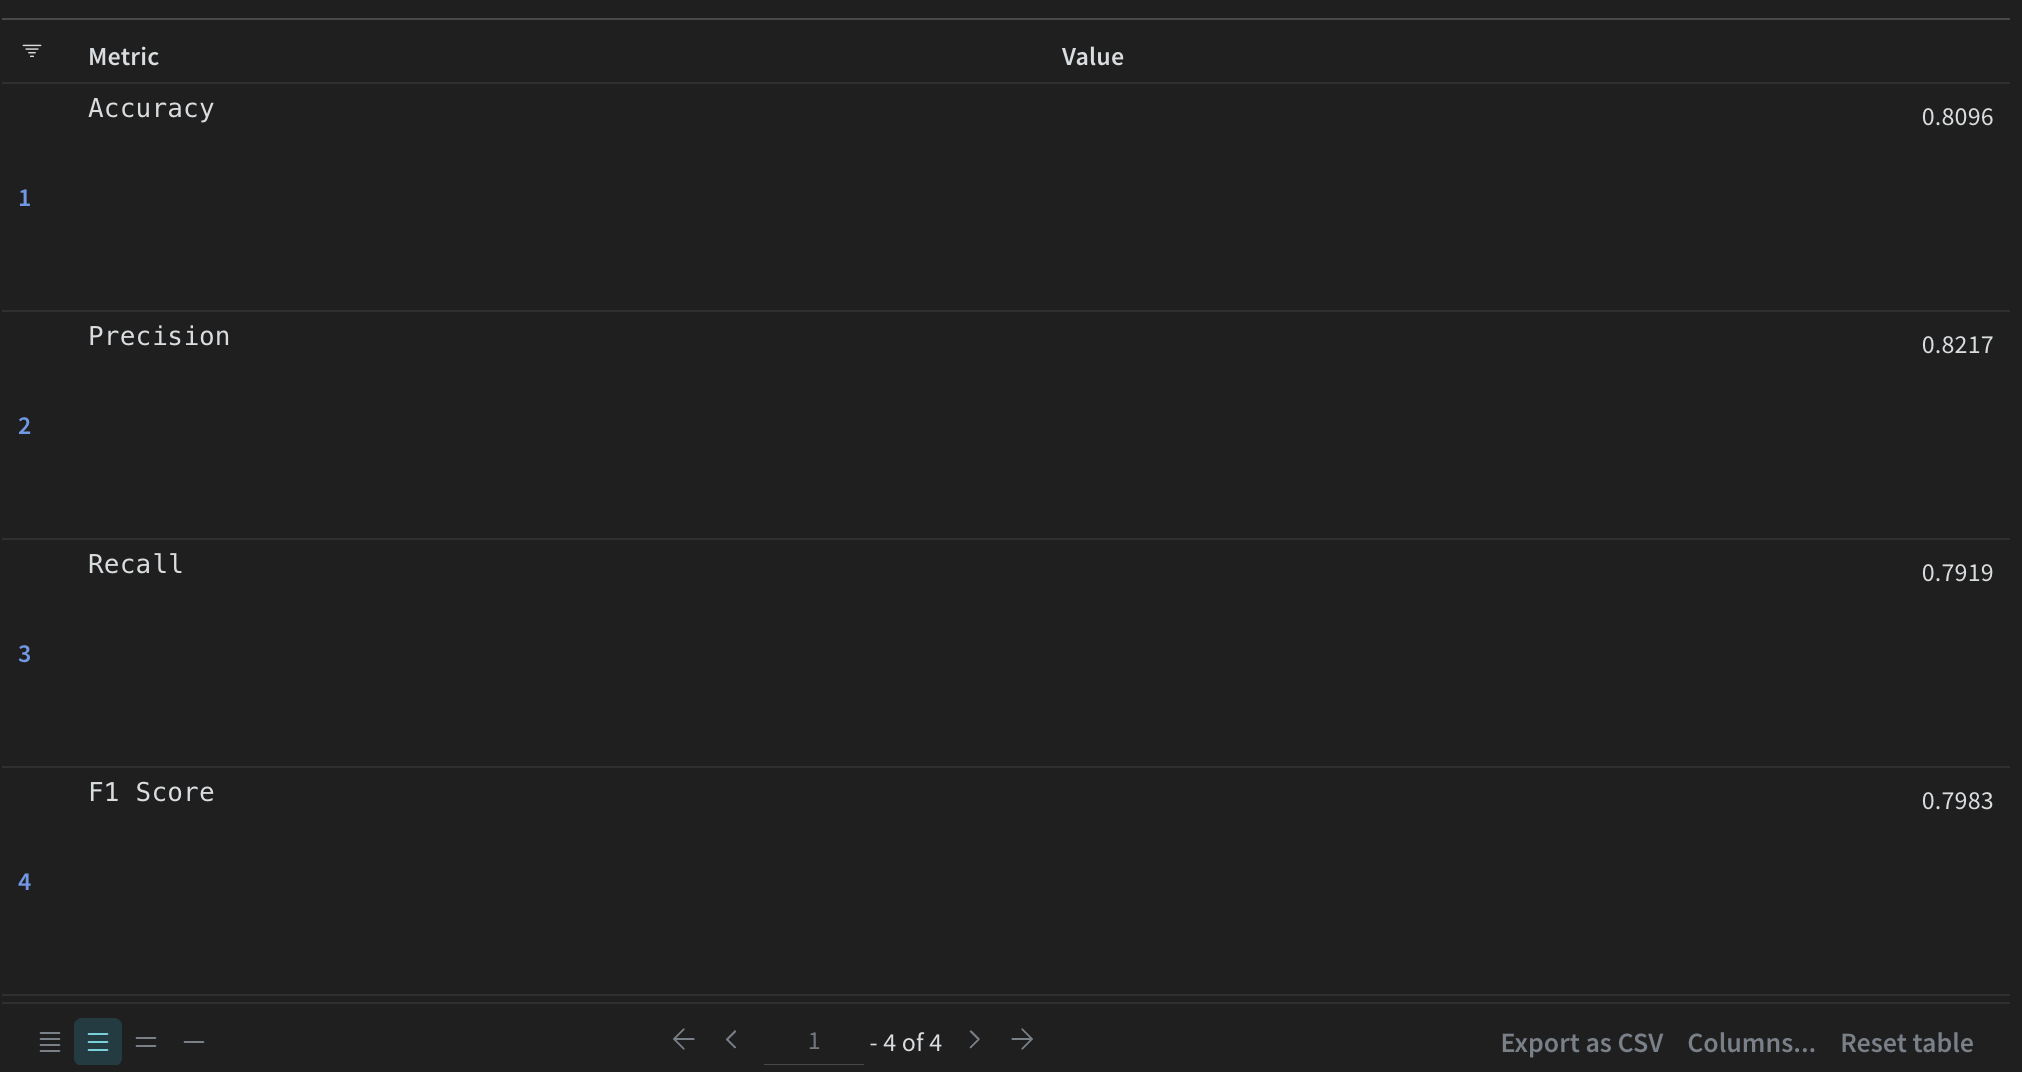

### Run Link:
https://wandb.ai/adarsh047/Disaster%20Tweet%20Classification?nw=nwuseradarsh047

# Choosing and Saving the best model

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_cv))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       869
           1       0.86      0.67      0.75       654

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.80      1523
weighted avg       0.82      0.81      0.81      1523



In [36]:
print(classification_report(y_val, y_pred_tv))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       869
           1       0.84      0.70      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



### From the above results we can see that the `TFIDF` model is performing slightly better than the other models

Let's Save the model and the vectorizer

In [38]:
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(tfif_vectorizer, f)

In [39]:
with open("tfidf.pkl", "wb") as f:
    pickle.dump(svc_tfidf_tv, f)